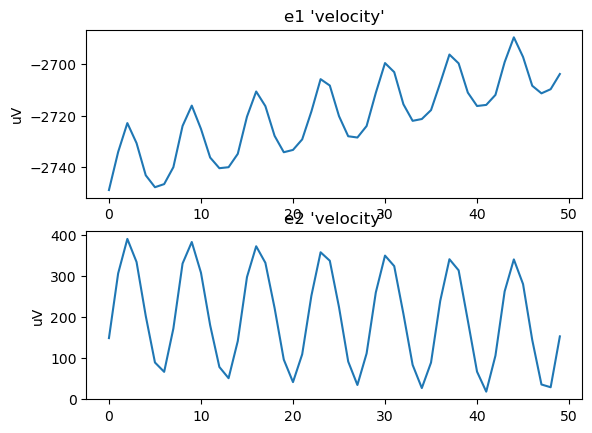

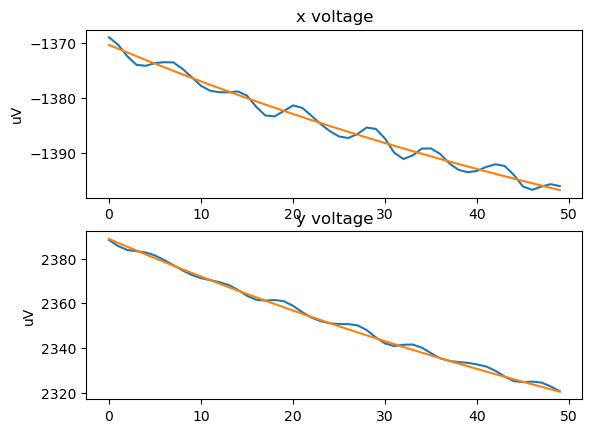

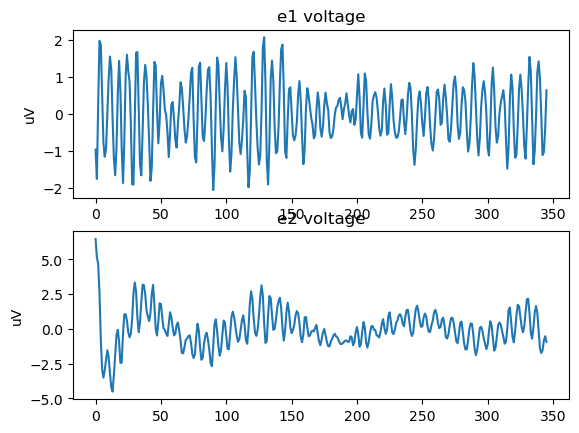

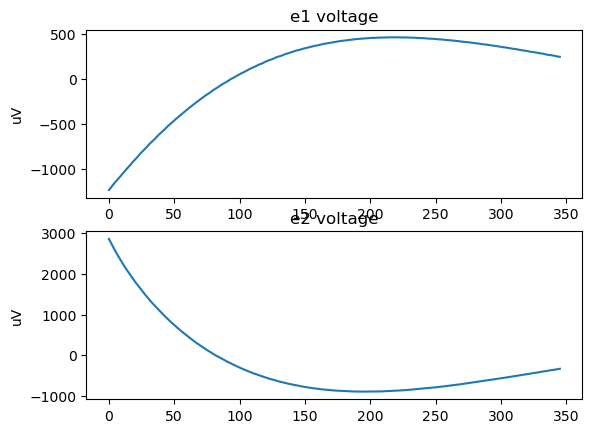

In [13]:
"""
Try processing without taking a fit to each sensor...First rotate E1 and E2 to x and y voltage
"""


from scipy.io import loadmat
from scipy import signal
from scipy.io import netcdf
import numpy as np
import time
import pyIGRF
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#from wavesim1d import *
from src.em_apex_processing import *
from src.spectral_processing import *
import os
import warnings



#########################
#####Define Constants####
#########################
Cmax=10
uVpc = 1e6 * (10e-3 / (2**24))

#Degree of polynomial fit
Nfit=1

nstep_off=25
navg_off=50
base_fr=0.02

ch=0.06
cz=0.09

nstep = 60
navg = 120 
Zmax=100
Dirmax=80
#electrode separation
esep1 = (8+5/8)*0.0254 # m
esep2 = (8+5/8)*0.0254 # m
c1 = 0.5
c2 = -0.2
# angles between compass and electrode axes
alpha2 = 1.95
alpha1 = alpha2 - np.pi/2

###########################


### Load Files ###
#For loading from harddrive
#fname_base = "/Volumes/TFO-5TB-3/TFO/LCDRI/raw_data/"
#For loading from laptop
fname_base = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/"
save_dir = "/Volumes/TFO-5TB-3/TFO/LCDRI/processed_data/James_output/Spectra/"
float_list = os.listdir(fname_base)

#Initialize arrays for storing stuff
big_spec_store = []
big_time_store = []
big_up_down_store = []
big_prof_store = []
big_uncertainty_store = []
resid_store = np.array([])

#For investigating down profiles
#down_min_z = []
#up_min_z =[]


up = True

float_id_counter = 0
ignore_count = 0
too_deep_counter = 0
min_bin = []
first_bot = []

##Testing for nans -- TO DO: Think we can delete this nan stuff
nancounter = 0
nanstorer = []
float_list = ['6667g']
for float_id in float_list:
    
    #Ignore non profile files in this directory
    if "grid" in float_id:
        continue
    if ".DS_" in float_id:
        continue
        
    dec_name = fname_base+float_id+"/dec/"
    
    #Loop through each profile for that float
    files = os.listdir(dec_name)
    efr_files = [file for file in files if "efr.mat" in file and not file.startswith('.')]
    
    spec_store = np.zeros((len(efr_files), 2 , 59))
    time_store = np.zeros(len(efr_files))
    up_down_store = np.zeros(len(efr_files))
    uncertainty_store = np.zeros((len(efr_files), 2))
    prof_store = np.empty(len(efr_files), dtype=object)
    counter=0
    #Load each profiling file, and then calculate the 1D spectrum
    efr_files = [efr_files[0]]
    for file in efr_files:
        fname = dec_name + file
        EFR = loadmat(fname)

        
        prof_num = int(file.split('-')[2])
        #Load the UXT times, and correct
        
        efr_times = EFR['UXT'] - EFR['AGE']
        efr_times = efr_times[0, :]
        seqno = EFR['SEQNO'][0, :]
        
        #Fit UXT times to sequence number (measurement # for that profile) to make sure monotonically increasing
        p = np.polyfit(seqno,efr_times,1)
        pfit = np.poly1d(p)
        mlt_efr = pfit(seqno);

        
        #Load GPS file for calculating 
        # gps files are only on up profiles (even)
        if prof_num%2==0:
            up = True
            cut = fname.find("efr")
            gpsfname = fname[:cut]+"gps.mat"
        else:
            up = False
            new_file = file.split('-')[0]+'-'+file.split('-')[1]+'-{:04d}'.format(prof_num+1)+'-gps.mat'
            gpsfname = dec_name+new_file
        GPS = loadmat(gpsfname)

        #Load CTD file 
        cut = fname.find("efr")
        ctdfname = fname[:cut]+"ctd.mat"
        CTD = loadmat(ctdfname)
        
        ctd_time = CTD["UXT"][0, :]
        P = CTD["P"][0, :]
        Pef = np.interp(mlt_efr, ctd_time, P)

        tim_pd = pd.to_datetime(GPS["UXT_GPS"][0, :],unit='s', utc=True,)
        #Convert time to fractional year for use in the igrf function
        frac_yrs = np.array([year_fraction(dt) for dt in tim_pd])
        avg_lat = np.nanmean(GPS["LAT"][0, :])
        avg_lon = np.nanmean(GPS["LON"][0, :])
        avg_frac_yrs = np.nanmean(frac_yrs)

        #Get magnetic field values
        [Bx, By, Bz, f] = pyIGRF.calculate.igrf12syn(avg_frac_yrs, 1, 0, avg_lat, avg_lon)

        #get conversion factor for converting to velocity
        fz=-np.nanmean(Bz);
        fh=np.nanmean(np.sqrt(Bx**2+By**2));
        sfv1 = 1e3/(fz*esep1*(1.0+c1));
        sfv2 = 1e3/(fz*esep2*(1.0+c1));
        
        #Convert from counts to microvolts
        E1 = (EFR["E1"][0, :]-2**23) * uVpc;
        E2 = (EFR["E2"][0, :]-2**23) * uVpc;
        
        #pull out compass values
        HZ = EFR["HZ"][0, :];
        HY = EFR["HY"][0, :];
        HX = EFR["HX"][0, :];
        
        
        #If up is true, flip everything
        if up:
            E1 = np.flip(E1)
            E2 = np.flip(E2)
            HZ = np.flip(HZ)
            HX = np.flip(HX)
            HY = np.flip(HY)
            Pef = np.flip(Pef)
            mlt_efr = np.flip(mlt_efr)
        
        else:
            #Do Nothing
            pass
            
        
        #Remove the beginning of the timesereis before the float starts moving
        #Need to do this for all of E1, E2, HX, HY, mlt_efr
        moving_inds = get_moving_inds(Pef)
        
        #Uncomment this to print out the filenames where EM starts before CTD
        #if len(moving_inds)<len(Pef):
            #print(len(Pef)-len(moving_inds), fname)
            #continue
            
        #Apply moving_inds to the EM timeseries
        E1 = E1[moving_inds]
        E2 = E2[moving_inds]
        HX = HX[moving_inds]
        HY = HY[moving_inds]
        mlt_efr = mlt_efr[moving_inds]
        Pef_moving = Pef[moving_inds]
        
        #Do the 50s fits 
        [e1offs,e2offs,e1fits,e2fits, anghxhy, resid] = em_offset(Nfit,mlt_efr,nstep_off,navg_off,E1,E2,HX,HY);

        e1 = E1#*sfv1
        e2 = E2#*sfv2
        
        avg_angs = np.copy(anghxhy)
        avg_angs[~np.isnan(avg_angs)] = np.unwrap(avg_angs[~np.isnan(avg_angs)])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            avg_angs = np.nanmean(avg_angs, axis=1)


        e_y=e2*np.cos(avg_angs)+e1*np.sin(avg_angs);
        e_x=-e2*np.sin(avg_angs)+e1*np.cos(avg_angs);


        
        
        Nfit = 8
        con = np.ones(mlt_efr.shape[0]);
        trnd = mlt_efr - mlt_efr[0]; # trend
        trnd = trnd / (max(trnd)-min(trnd)) 
        BASIS=np.expand_dims(con, axis=1)
        for k in range(1, Nfit+1):
            BASIS=np.concatenate((BASIS,np.expand_dims(trnd**k, axis=1)), axis=1) 

            
        [COEF1, resid1, rank, s] = np.linalg.lstsq(BASIS, e1, rcond=None) # least squares fit
        [COEF2, resid2, rank, s] = np.linalg.lstsq(BASIS, e2, rcond=None)
        
        e1b=con*COEF1[0]; #Fitted result of background constant
        e2b=con*COEF2[0];    
        e1f=con*COEF1[0]; #Fitted result of the curve
        e2f=con*COEF2[0];

        for k in range(1, Nfit+1):
            e1b=e1b+COEF1[0+k]*trnd**k; #the revised results of voltage offset by adding trend
            e2b=e2b+COEF2[0+k]*trnd**k;
            e1f=e1f+COEF1[0+k]*trnd**k;
            e2f=e2f+COEF2[0+k]*trnd**k;    
         
        
        plt.figure()
        plt.subplot(211)
        plt.plot(e_x[100:150])
        plt.ylabel('uV')
        plt.title("e1 'velocity'")
        plt.subplot(212)
        plt.plot(e_y[100:150])

        plt.ylabel('uV')
        plt.title("e2 'velocity'")
        
        plt.figure()
        plt.subplot(211)
        plt.plot(e1[100:150])
        plt.plot(e1f[100:150])
        plt.ylabel('uV')
        plt.title("x voltage")
        plt.subplot(212)
        plt.plot(e2[100:150])
        plt.plot(e2f[100:150])

        plt.ylabel('uV')
        plt.title("y voltage")
        
        plt.figure()
        plt.subplot(211)
        plt.plot(e1-e1f)
        plt.ylabel('uV')
        plt.title("e1 voltage")
        plt.subplot(212)
        plt.plot(e2-e2f)
        plt.ylabel('uV')
        plt.title("e2 voltage")
        
        
        
        #How about just trying a highpass filter to get rid of anything slower than 120s
        
        sos = signal.butter(4, 0.001, 'hp', fs=1, output='sos')
        e1_filtered = signal.sosfilt(sos, e1)
        e2_filtered = signal.sosfilt(sos, e2)
        plt.figure()
        plt.subplot(211)
        plt.plot(e1_filtered)
        plt.ylabel('uV')
        plt.title("e1 voltage")
        plt.subplot(212)
        plt.plot(e2_filtered)
        plt.ylabel('uV')
        plt.title("e2 voltage")

In [10]:
HX[0]
HY[0
   
np.atan2(HX[0]/HY[0])

SyntaxError: invalid syntax (1027551696.py, line 4)

In [15]:
anghxhy[0, 0]
avg_angs[0]

0.9213143339377241

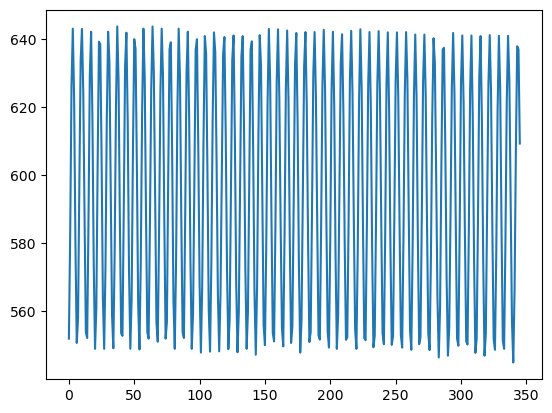

In [39]:
plt.plot(HX)

In [85]:
t = mlt_efr
navg = 10
nstep = 5
nblock = (len(t)//nstep)-1
anghxhy = np.empty((len(t), nblock))
anghxhy.fill(np.nan)


nout = 0

for i1 in range(0, len(t)-navg, nstep):
    j = list(range(i1, i1+navg))
    hx = HX[j];
    hy = HY[j];
    #hx = hx - np.nanmean(hx)
    #hx = (hx / np.std(hx)) / np.sqrt(2)
    #hy = hy - np.nanmean(hy)
    #hy = (hy / np.std(hy)) / np.sqrt(2)
    angs=np.arctan2(hx,hy);
    anghxhy[j,nout]=angs;    
    nout +=1

In [86]:
angs = np.nanmean(anghxhy, axis=1)

/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_8061/3354817693.py:1: RuntimeWarning: Mean of empty slice
  angs = np.nanmean(anghxhy, axis=1)


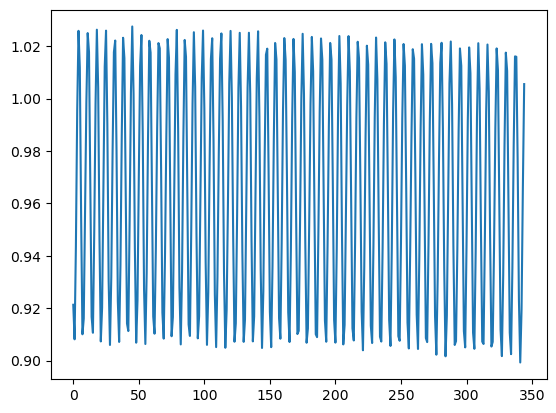

In [87]:
plt.plot(angs)

In [5]:
anghxhy[76, 2]-anghxhy[76, 3]

0.0

In [89]:
print(anghxhy[5:10, 0])
print(anghxhy[5:10, 1])

[1.01173214 0.95483839 0.91005776 0.9160497  0.95575044]
[1.01173214 0.95483839 0.91005776 0.9160497  0.95575044]
